In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cvxpy as cp

from cartpole.cartpole import Cartpole
import pickle, os

In [2]:
#load train/test data
prob = Cartpole() #use default config, pass different config file oth.
config_fn = './cartpole/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/cartpole/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
train_file.close()

test_file = open(dataset_fn+'/test.p','rb')
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, c_test, times_test = test_data
test_file.close()

n_test = x_test.shape[0]

# test MLOPT solver

In [3]:
from solvers.mlopt import MLOPT

system = 'cartpole'
prob_features = ['x0', 'xg']
mlopt_obj = MLOPT(system, prob, prob_features)

n_features = 8
mlopt_obj.construct_strategies(n_features, train_data)
print(mlopt_obj.n_strategies)

589


In [4]:
mlopt_obj.setup_network()

fn_saved = 'models/mlopt_cartpole_20200708_1029.pt'
mlopt_obj.load_network(fn_saved)

mlopt_obj.model

Loading presaved classifier model from models/mlopt_cartpole_20200708_1029.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=589, bias=True)
  )
)

In [ ]:
mlopt_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_obj.train(verbose=False)
print(mlopt_obj.model_fn)

In [ ]:
n_succ = 0
count = 0

costs_mlopt = []
total_time_mlopt = []
num_solves_mlopt = []

cost_ratios_mlopt = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals = mlopt_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_mlopt += [cost]
            total_time_mlopt += [total_time]
            num_solves_mlopt += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_mlopt += [cost / true_cost]
    except:
        print('Solver failed at {}'.format(ii))
        continue

costs_mlopt = np.array(costs_mlopt)
cost_ratios_mlopt = np.array(cost_ratios_mlopt)
total_time_mlopt = np.array(total_time_mlopt)
num_solves_mlopt = np.array(num_solves_mlopt, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

mlopt_percentage = 100 * float(n_succ) / float(count)
mlopt_percentage

0 / 10000


# test Regression solver

In [5]:
from solvers.regression import Regression

system = 'cartpole'
prob_features = ['x0', 'xg']
reg_obj = Regression(system, prob, prob_features)

n_features = 8
reg_obj.construct_strategies(n_features, train_data)

In [6]:
reg_obj.setup_network()

fn_saved = 'models/regression_cartpole_20200708_1029.pt'
reg_obj.load_network(fn_saved)

reg_obj.model

Loading presaved regression model from models/regression_cartpole_20200708_1029.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=40, bias=True)
  )
)

In [ ]:
reg_obj.training_params['TRAINING_ITERATIONS'] = 500
reg_obj.train(verbose=False)
print(reg_obj.model_fn)

In [ ]:
n_succ = 0
count = 0

costs_reg = []
total_time_reg = []
num_solves_reg = []

cost_ratios_reg = []

for ii in range(n_test):
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time = reg_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_reg += [cost]
            total_time_reg += [total_time]
            num_solves_reg += [1]

            true_cost = c_test[ii]
            cost_ratios_reg += [cost / true_cost]
    except:
        print('Solver failed at {}'.format(ii))
        continue

costs_reg = np.array(costs_reg)
cost_ratios_reg = np.array(cost_ratios_reg)
total_time_reg = np.array(total_time_reg)
num_solves_reg = np.array(num_solves_reg, dtype=int)

reg_percentage = 100 * float(n_succ) / float(count)
reg_percentage

# Results

In [9]:
import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd

flierprops = {'alpha':0.2}

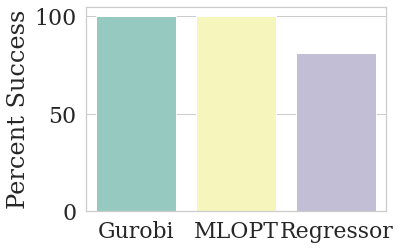

In [10]:
results = {'Gurobi':[100.], 'MLOPT':[mlopt_percentage], 'Regressor':[reg_percentage]}
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
# # figure.savefig("loss.pdf")

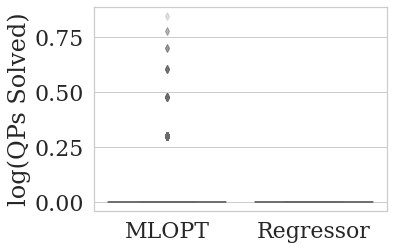

In [11]:
results = {}
results['Policy'] = ['MLOPT']*len(num_solves_mlopt) + ['Regressor']*len(num_solves_reg)
results['Solves'] = np.hstack((np.log10(num_solves_mlopt), np.log10(num_solves_reg)))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Solves'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(QPs Solved)")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

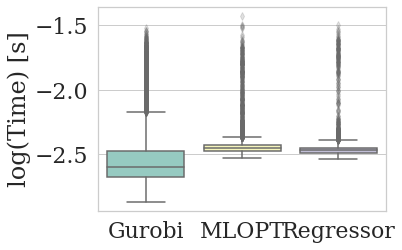

In [16]:
results = {}
results['Policy'] = ['Gurobi']*len(total_time_ip) +  ['MLOPT']*len(total_time_mlopt) + ['Regressor']*len(total_time_reg)
results['Time'] = np.hstack((np.log10(total_time_ip), np.log10(total_time_mlopt), np.log10(total_time_reg)))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Time'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(Time) [s]")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

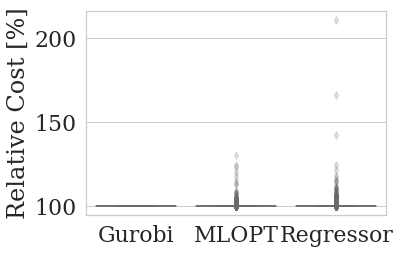

In [17]:
results = {}
results['Policy'] = ['Gurobi']*len(costs_ip) + ['MLOPT']*len(cost_ratios_mlopt) + ['Regressor']*len(cost_ratios_reg)
results['Costs'] = np.hstack((100*np.ones(len(costs_ip)), 100*cost_ratios_mlopt, 100*cost_ratios_reg))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="Relative Cost [%]")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")